In [1]:
import numpy as np
import cobra
import cobra.test
import pta
import matplotlib.pyplot as plt
import math
import glob
import os
import pandas as pd
import arviz as az
from scipy.stats import entropy

from pta.sampling.tfs import (
    TFSModel, 
    get_initial_points, 
    sample_drg,
    sample_drg0_from_drg,
    sample_log_conc_from_drg,
    sample_fluxes_from_drg
)

%matplotlib inline

In [2]:
hops1 = pd.read_csv('/home/simon/Downloads/results_hops_25_05_20/ecoliBoxConstr_CHRR_nopt_0/ecoliBoxConstr_CHRR_nopt_0_states.csv',header=None)
hops2 = pd.read_csv('/home/simon/Downloads/results_hops_25_05_20/ecoliBoxConstr_CHRR_nopt_1/ecoliBoxConstr_CHRR_nopt_1_states.csv',header=None)

array([[<AxesSubplot:title={'center':'ana1.n'}>,
        <AxesSubplot:title={'center':'emp6.n'}>]], dtype=object)

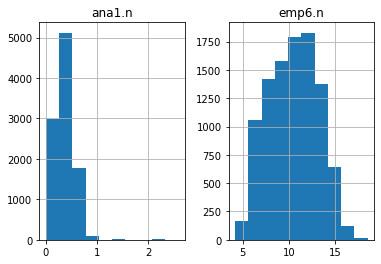

In [3]:
hops1.columns = ['BM_oaa1.x', 'BM_oaa1_aux.n', 'BM_oaa3.x', 'BM_oaa6_aux.n', 'BM_oga1.x', 'BM_oga1_aux.n', 'BM_pep3_aux.n', 'BM_pga1.x', 'BM_pyr2_aux.n', 'ana1.n', 'emp1.n', 'emp1.x', 'emp3.x', 'emp4.x', 'emp5.x', 'emp6.n', 'gneo1.n', 'gneo2.n', 'ppp2.x', 'ppp3.x', 'ppp4.x', 'ppp5.x', 'ppp6.x', 'tca1.n', 'tca5b.x', 'tca6.x', 'upt.n']
hops1[["ana1.n","emp6.n"]].hist()

array([[<AxesSubplot:title={'center':'ana1.n'}>,
        <AxesSubplot:title={'center':'emp6.n'}>]], dtype=object)

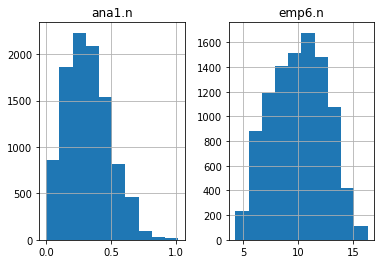

In [4]:
hops2.columns = ['BM_oaa1.x', 'BM_oaa1_aux.n', 'BM_oaa3.x', 'BM_oaa6_aux.n', 'BM_oga1.x', 'BM_oga1_aux.n', 'BM_pep3_aux.n', 'BM_pga1.x', 'BM_pyr2_aux.n', 'ana1.n', 'emp1.n', 'emp1.x', 'emp3.x', 'emp4.x', 'emp5.x', 'emp6.n', 'gneo1.n', 'gneo2.n', 'ppp2.x', 'ppp3.x', 'ppp4.x', 'ppp5.x', 'ppp6.x', 'tca1.n', 'tca5b.x', 'tca6.x', 'upt.n']
hops2[["ana1.n","emp6.n"]].hist()

In [5]:
#model1 = cobra.test.create_test_model("textbook")
#model1.reactions.Biomass_Ecoli_core.lower_bound = 0.5
model1 = cobra.io.read_sbml_model("/home/simon/pta/pta/data/models/e_coli_core.xml")
model1.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.1
model1.reactions.EX_glc__D_e.upper_bound = -1.9
model1.reactions.EX_glc__D_e.lower_bound = -2.7

Academic license - for non-commercial use only - expires 2021-11-04
Using license file /home/simon/gurobi.lic


In [7]:
us_model = pta.UniformSamplingModel.from_cobrapy_model(model1)
result1 = pta.sample_flux_space_uniform(us_model, 10000)
assert result1.check_convergence()


Starting simulation ...
------------------------------------------------
    worker |  time (s) |     steps |   steps/s  
------------------------------------------------
Done.


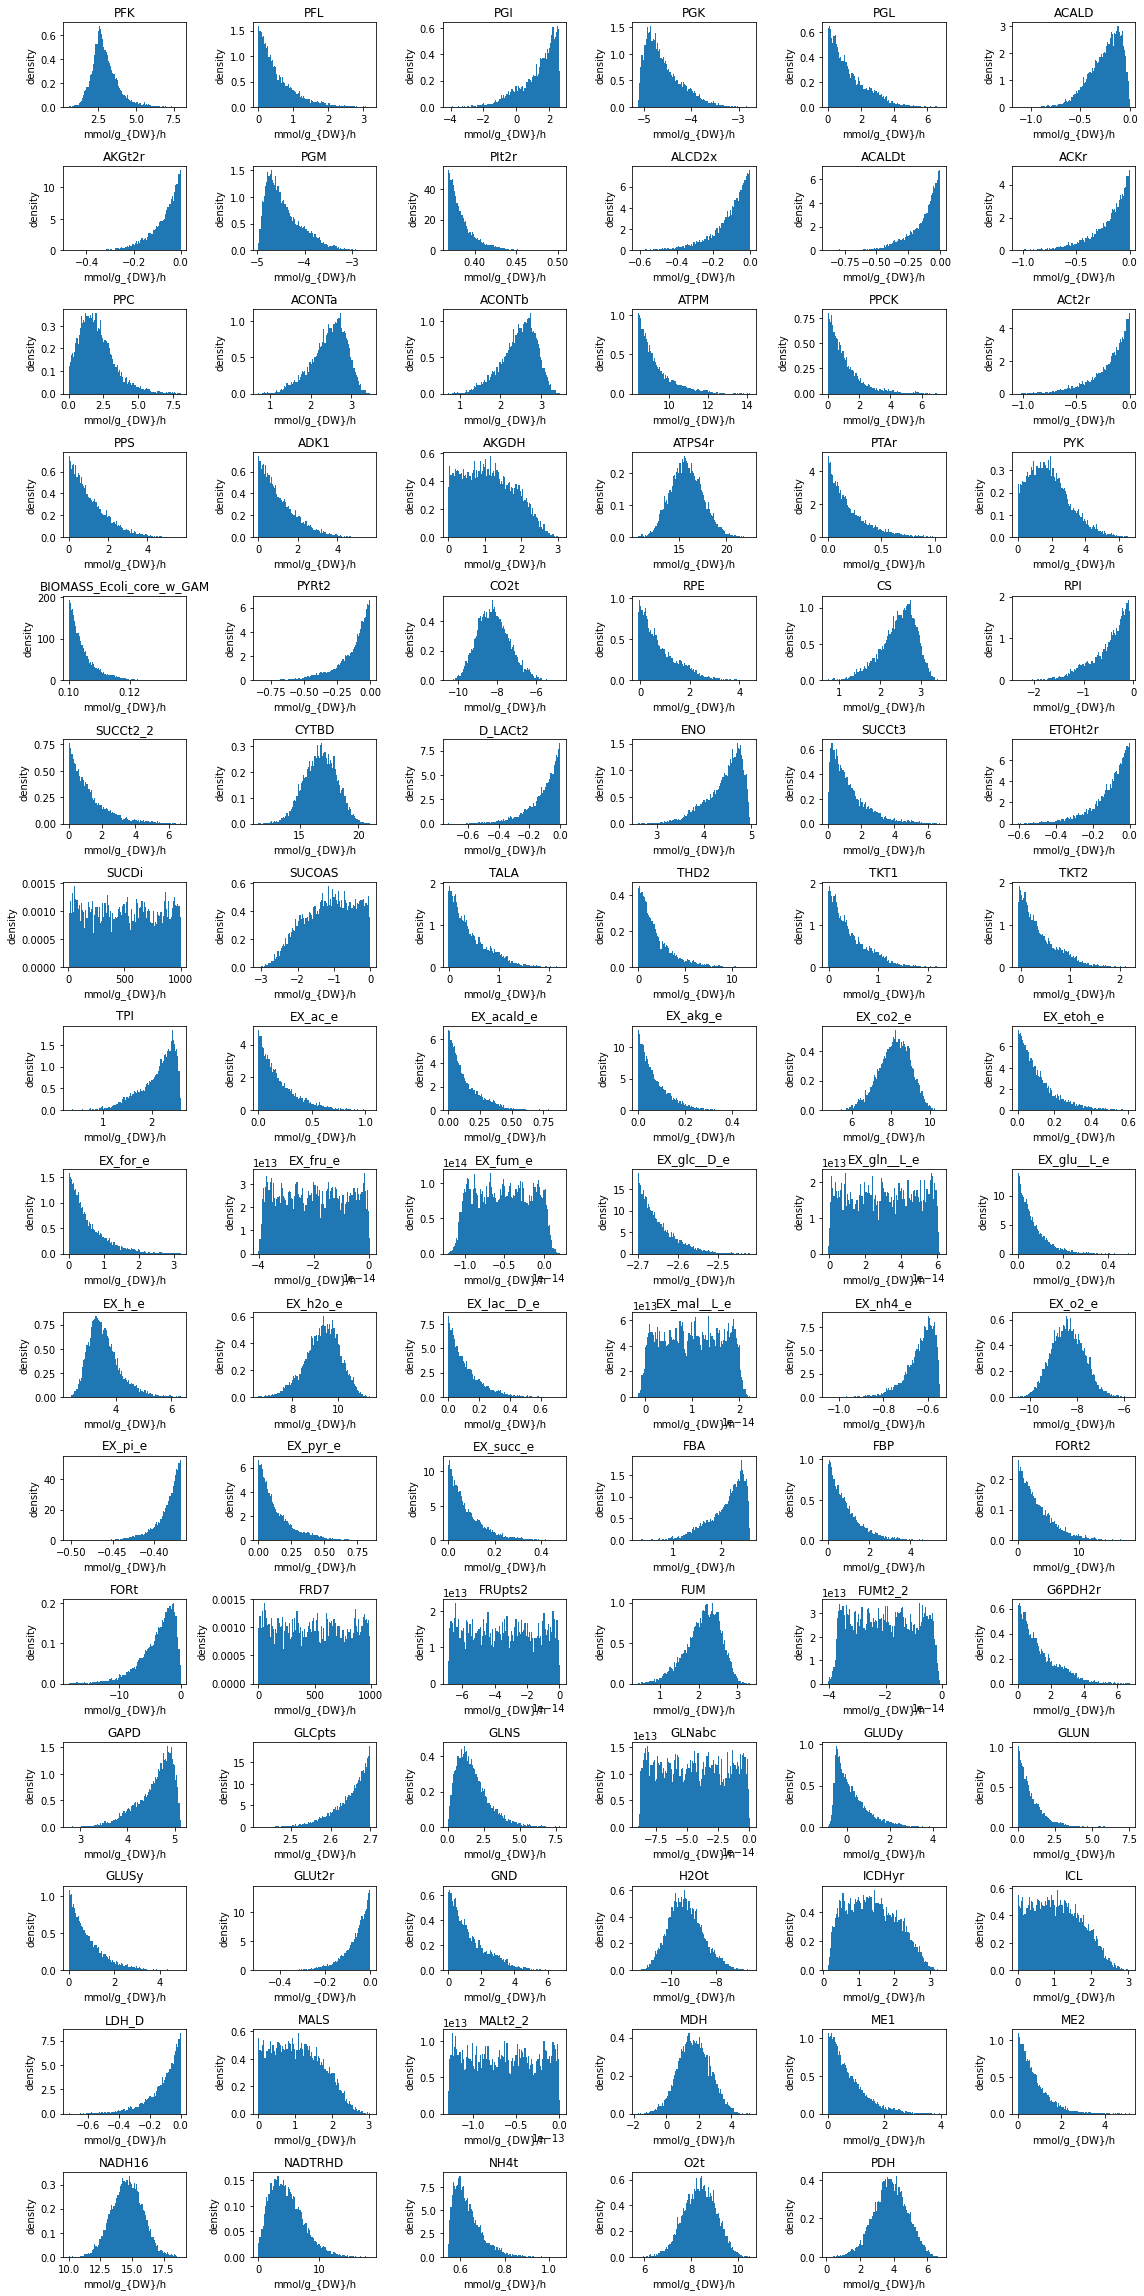

95

In [10]:
num_rxns = result1.samples.shape[1]
n_cols = 6
n_rows = math.ceil(num_rxns / n_cols)

fig=plt.figure(figsize=(16, 2*n_rows))
for i in range(num_rxns):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    ax.hist(result1.samples.iloc[:, i], bins=100, density=True)
    ax.set_title(model1.reactions[i].id)
    ax.set_xlabel('mmol/g_{DW}/h')
    ax.set_ylabel('density')
fig.tight_layout()
plt.show()
num_rxns

In [8]:
#model = cobra.test.create_test_model("textbook")
#model.reactions.Biomass_Ecoli_core.lower_bound = 0.5
model = cobra.io.read_sbml_model("/home/simon/pta/pta/data/models/e_coli_core.xml")
model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.1
#model.reactions.EX_glc__D_e.upper_bound = -1.9
#model.reactions.EX_glc__D_e.lower_bound = -2.7
pta.prepare_for_pta(model)
model.reactions.EX_glc__D_e.upper_bound = -1.9
model.reactions.EX_glc__D_e.lower_bound = -2.7
thermodynamic_space = pta.ThermodynamicSpace.from_cobrapy_model(
    model, parameters=pta.CompartmentParameters.load("e_coli")
)

Read LP format model from file /tmp/tmplk3ddqdi.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


/home/simon/.local/lib/python3.8/site-packages/pint/quantity.py:1885: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._magnitude[key] = factor.magnitude


In [9]:
tfs_model = TFSModel(model, thermodynamic_space, solver="GUROBI")
result = sample_drg(tfs_model,num_steps=150000) ###try increasing warmup

In [10]:
log_conc = sample_log_conc_from_drg(thermodynamic_space, result.samples)
drg0 = sample_drg0_from_drg(thermodynamic_space, result.samples)
fluxes = sample_fluxes_from_drg(model, result.samples, result.orthants,num_approx_samples=10000)

Read LP format model from file /tmp/tmp0h0uq18v.lp
Read LP format model from file /tmp/tmp4avdzx0s.lp
Reading time = 0.01 seconds
Reading time = 0.00 seconds
Read LP format model from file /tmp/tmpyahdajle.lp
: 68 rows, 174 columns, 674 nonzeros
: 68 rows, 174 columns, 674 nonzeros
Reading time = 0.01 seconds
Read LP format model from file /tmp/tmp2xrmpvkq.lp
Reading time = 0.02 seconds
Read LP format model from file /tmp/tmpfgdyi3q_.lp
Reading time = 0.07 seconds
: 68 rows, 174 columns, 674 nonzeros
: 68 rows, 174 columns, 674 nonzeros
Read LP format model from file /tmp/tmpz5xqa_lf.lp
: 68 rows, 174 columns, 674 nonzeros
Read LP format model from file /tmp/tmp5sk3m3xm.lp
Reading time = 0.03 seconds
Reading time = 0.01 seconds
: 68 rows, 174 columns, 674 nonzeros
Read LP format model from file /tmp/tmpwp1tts2y.lp
Reading time = 0.03 seconds
: 68 rows, 174 columns, 674 nonzeros
: 68 rows, 174 columns, 674 nonzeros

Starting simulation ...
-----------------------------------------------

def plot_samples(samples, x_log = False):
    num_plots = samples.shape[1]
    n_cols = 8
    n_rows = math.ceil(num_plots / n_cols)

    fig=plt.figure(figsize=(16, 1.6*n_rows))
    for i in range(num_plots):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if x_log:
            hist, bins = np.histogram(samples.iloc[:,i], bins=20)
            logbins = np.logspace(np.log(bins[0]), np.log(bins[-1]), len(bins), base=np.e)
            ax.hist(samples.iloc[:,i], bins=logbins)
            plt.xscale('log')
        else:
            ax.hist(samples.iloc[:,i], bins=20, density=True)
        ax.set_title(samples.columns[i])
    fig.tight_layout()
    plt.show()
    print(num_plots)

In [11]:
updated = result1.samples.loc[:,fluxes.columns]

In [12]:
fluxes[:-1]

,PFK,PFL,PGI,PGK,PGL,ACALD,AKGt2r,PGM,PIt2r,ALCD2x,...,LDH_D,MALS,MDH,ME1,ME2,NADH16,NADTRHD,NH4t,O2t,PDH
0,1.016910,0.249266,-5.083900,-2.479924,7.725127,-0.097761,-0.006618,-2.328556,0.372219,-0.044180,...,-0.101688,0.643160,-1.038889,2.110276,0.208873,19.445909,15.387366,0.603980,10.041505,1.807384
1,0.009728,0.578680,-5.534606,-2.322407,8.172196,-0.056635,-0.070931,-2.170228,0.374213,-0.029573,...,-0.033870,0.422115,-0.238177,0.953309,0.080653,19.262589,20.692683,0.564155,9.818129,1.094669
2,0.243879,0.785204,-5.078870,-2.484255,7.725118,-0.281664,-0.039837,-2.329085,0.381568,-0.002975,...,-0.245857,0.108873,-0.217086,0.132664,0.463549,17.338362,23.754556,0.598324,8.804308,0.583340
3,1.168255,0.921964,-5.024740,-2.471469,7.651480,-0.181316,-0.005222,-2.317419,0.378812,-0.180095,...,-0.151110,0.182921,-0.119065,0.546839,0.166290,17.637571,16.555480,0.616456,9.024357,0.579790
4,0.689714,0.413148,-5.303465,-2.407576,7.945166,-0.155127,-0.001422,-2.256241,0.372135,-0.101392,...,-0.140196,0.273436,-0.136699,0.709452,0.170782,18.912604,26.762019,0.560723,9.691352,1.126792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.775573,0.158250,-0.174897,-3.912687,2.693762,-0.042156,-0.036790,-3.761561,0.371622,-0.033264,...,-0.093547,0.352981,-0.135390,1.766628,0.335790,14.944090,6.004919,0.592080,8.279069,2.560946
9996,1.954513,0.007109,-2.232407,-3.472479,4.902313,-0.400433,-0.137749,-3.317290,0.381613,-0.108983,...,-0.009469,0.128840,-0.198883,0.428327,0.394213,15.291669,10.418478,0.765111,7.893243,2.170658
9997,1.368508,0.265210,-1.611640,-3.692181,4.289852,-0.051244,-0.069423,-3.536285,0.383352,-0.034341,...,-0.058608,0.320489,-0.473814,1.731863,0.255667,16.455082,10.890596,0.620932,8.824154,2.368171
9998,1.453744,0.159449,-0.917376,-3.845139,3.556388,-0.346090,-0.129195,-3.680505,0.404838,-0.169816,...,-0.072492,0.120891,-0.406065,0.369586,1.386310,15.478978,11.363549,0.600561,8.353959,2.437451


In [13]:
updated

,PFK,PFL,PGI,PGK,PGL,ACALD,AKGt2r,PGM,PIt2r,ALCD2x,...,LDH_D,MALS,MDH,ME1,ME2,NADH16,NADTRHD,NH4t,O2t,PDH
0,1.757495,0.345961,0.166280,-4.129331,2.416817,-0.148683,-0.070218,-3.975455,0.378385,-0.095218,...,-0.050410,0.541299,1.118057,0.745418,0.636586,15.997351,9.798076,0.575050,8.978057,3.260154
1,2.247199,1.405613,0.437427,-4.361109,2.231999,-0.053608,-0.004342,-4.205578,0.382454,-0.025850,...,-0.035083,0.295636,0.074817,0.763049,0.954329,13.252577,6.239651,0.648502,7.374568,1.691679
2,2.849096,0.654262,1.843761,-4.818286,0.827284,-0.202521,-0.044528,-4.653240,0.405850,-0.007296,...,-0.013189,0.990219,0.784545,1.835780,0.995006,15.775422,4.719128,0.621567,9.200267,4.087569
3,3.951014,0.331361,2.601675,-5.078185,0.070227,-0.131868,-0.015863,-4.917020,0.396307,-0.020024,...,-0.072889,0.601111,0.787717,1.555620,0.868127,14.833094,1.935065,0.920379,8.721724,3.977150
4,1.965801,0.450236,0.602333,-4.401179,2.064150,-0.118300,-0.086280,-4.238998,0.398806,-0.037606,...,-0.177207,1.916899,1.105331,2.561712,0.509557,16.432408,5.835629,0.592667,9.346054,4.703332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.822912,0.077650,1.722297,-4.730209,0.917100,-0.621359,-0.011056,-4.568596,0.397410,-0.353245,...,-0.060984,1.466573,3.202128,0.034809,0.528186,14.584335,1.456287,0.632333,8.441443,5.071099
9996,3.392748,0.500399,1.232818,-4.563718,1.396509,-0.238734,-0.113302,-4.411055,0.375401,-0.208477,...,-0.308993,0.568123,1.493563,0.626551,0.494568,14.188556,3.975352,0.599395,8.117558,3.105973
9997,5.812181,0.074638,0.025825,-4.197150,2.623828,-0.317410,-0.084260,-4.045742,0.372315,-0.293512,...,-0.065444,1.157077,2.436119,0.302427,0.203660,15.939278,5.594419,0.551970,8.862203,3.950337
9998,2.520579,1.023932,2.103042,-4.857529,0.528728,-0.219106,-0.137996,-4.704644,0.375948,-0.080952,...,-0.198220,0.850158,2.134866,0.366656,0.347037,12.453943,6.762256,0.935712,7.226172,3.125786


entropy(updated["ACALDt"][:-1],fluxes["ACALDt"])

from scipy.ndimage.filters import gaussian_filter

def kl(p, q):
    p = np.asarray(p, dtype=float) + 0.00001
    q = np.asarray(q, dtype=float) + 0.00001

    return entropy(p,q)#np.sum(np.where(p != 0, p * np.log(p / q), 0))

def smoothed_hist_kl_distance(a, b, nbins=50, sigma=5):
    ahist, bhist = (np.histogram(a, bins=nbins)[0],
                    np.histogram(b, bins=nbins)[0])

    asmooth, bsmooth = (gaussian_filter(ahist, sigma),
                        gaussian_filter(bhist, sigma))

    return kl(asmooth, bsmooth)

smoothed_hist_kl_distance(updated["ATPM"],fluxes["ATPM"][:-1])

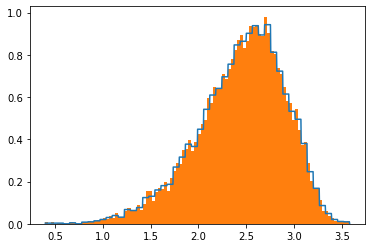

In [14]:
import scipy.stats
X = np.linspace(min(updated["ACONTb"]), max(updated["ACONTb"]), 1000)
aaaa = scipy.stats.rv_histogram(np.histogram(updated["ACONTb"], bins=50))
plt.plot(X, aaaa.pdf(X), label='PDF')
plt.hist(updated["ACONTb"], density=True, bins=100)
plt.show()

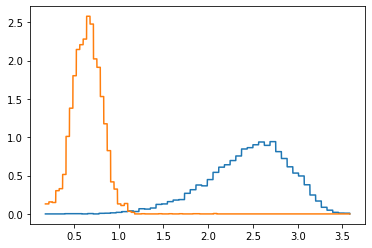

In [15]:
import scipy.stats
X = np.linspace(min(min(updated["ACONTb"].to_numpy()),min(fluxes["ACONTb"].to_numpy())), max(max(updated["ACONTb"].to_numpy()),max(fluxes["ACONTb"].to_numpy())), 10000)
#Xa = np.linspace(min(updated["ACONTb"]), max(updated["ACONTb"]), 100)
#Xb = np.linspace(min(fluxes["ACONTb"]), max(fluxes["ACONTb"]), 100)

aaaa = scipy.stats.rv_histogram(np.histogram(updated["ACONTb"][:10000], bins=50))
bbbb = scipy.stats.rv_histogram(np.histogram(fluxes["ACONTb"][:10000], bins=50))

plt.plot(X, aaaa.pdf(X), label='PDF')
plt.plot(X, bbbb.pdf(X), label='PDF')

#plt.hist(updated["ACONTb"], density=True, bins=100)
plt.show()

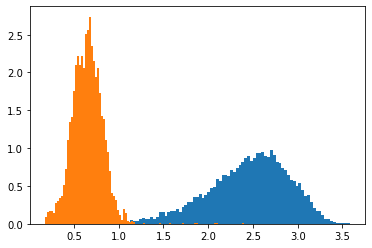

In [16]:
plt.hist(updated["ACONTb"], density=True, bins=100)
plt.hist(fluxes["ACONTb"], density=True, bins=100)

plt.show()

for i in updated.columns:
    X = np.linspace(min(updated[i]), max(updated[i]), 100)
    aaaa = scipy.stats.rv_histogram(np.histogram(updated[i], bins=50))
    plt.plot(X, aaaa.pdf(X), label='PDF')
    plt.hist(updated[i], density=True, bins=100)
    plt.show()

In [17]:
from scipy.ndimage.filters import gaussian_filter


def smoothed_hist_kl_distance(a, b, nbins=1000):
    ahist, bhist = (np.histogram(a, bins=nbins),
                    np.histogram(b, bins=nbins))
    #Xa = np.linspace(min(a), max(a), 100)
    #Xb = np.linspace(min(b), max(b), 100)
    X = np.linspace(min(min(a.to_numpy()),min(b.to_numpy())), max(max(a.to_numpy()),max(b.to_numpy())), 10000)
    asmooth, bsmooth = (scipy.stats.rv_histogram(ahist),
                        scipy.stats.rv_histogram(bhist))

    return entropy(asmooth.pdf(X)+0.0001, bsmooth.pdf(X)+0.0001)

smoothed_hist_kl_distance(updated["ACONTb"],fluxes["ACONTb"])

8.553957841286515

array([[<AxesSubplot:title={'center':'updated'}>,
        <AxesSubplot:title={'center':'luxes'}>]], dtype=object)

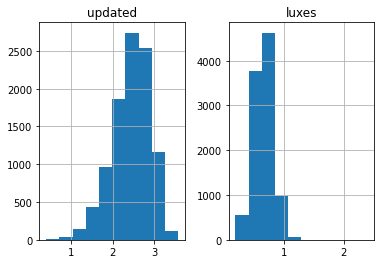

In [18]:
pd.DataFrame({"updated":updated["ACONTb"],f"luxes":fluxes["ACONTb"]}).hist()

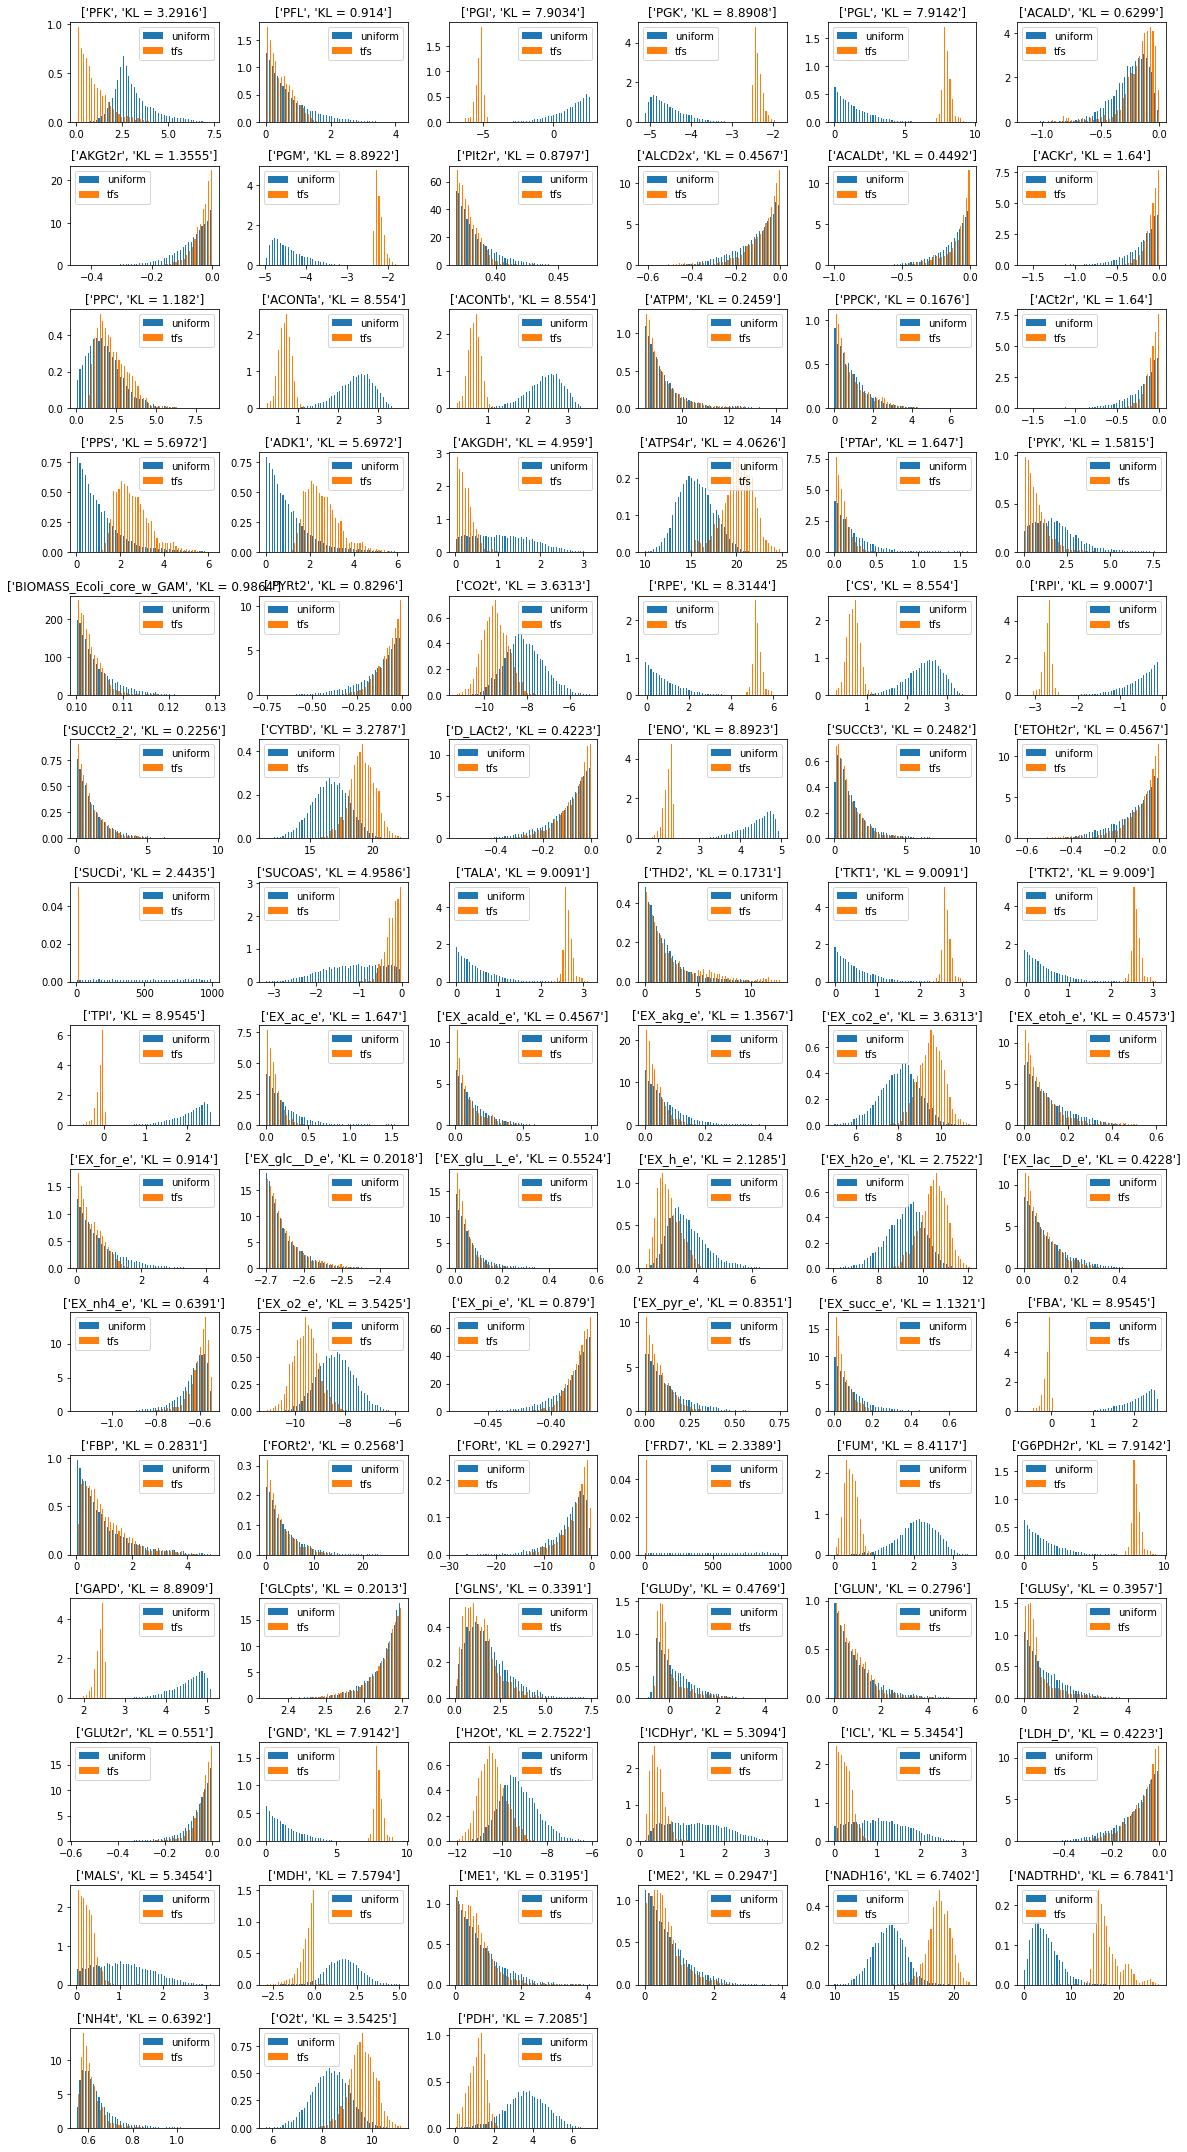

In [19]:
num_rxns = fluxes.shape[1]
n_cols = 6
n_rows = math.ceil(num_rxns / n_cols)

fig=plt.figure(figsize=(16, 2*n_rows))
for i in range(num_rxns):
    kldiv = round(smoothed_hist_kl_distance(updated.iloc[:, i],fluxes.iloc[:, i]),4)
    kldiv = "KL = " + str(kldiv)
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    ax.hist([updated[:10000].iloc[:, i],fluxes[:10000].iloc[:,i]], bins=50, density=True,label = ["uniform","tfs"])
    #X = np.linspace(min(min(updated[:10000].iloc[:, i]),min(fluxes[:10000].iloc[:, i])), max(max(updated[:10000].iloc[:, i]),max(fluxes[:10000].iloc[:, i])), 100)
    #aaaa = scipy.stats.rv_histogram(np.histogram(updated[:10000].iloc[:, i], bins=50))
    #bbbb = scipy.stats.rv_histogram(np.histogram(fluxes[:10000].iloc[:, i], bins=50))
    #ax.plot(X, aaaa.pdf(X), label='PDF')
    #ax.plot(X, bbbb.pdf(X), label='PDF')
    #fluxes.iloc[:, i]]
    ax.legend(prop={'size': 10})
    #ax.hist(, bins=20, density=True)
    ax.set_title([fluxes.columns[i],kldiv])#model1.reactions[i].id
fig.tight_layout()
plt.show()

array([[<AxesSubplot:title={'center':'PPC'}>]], dtype=object)

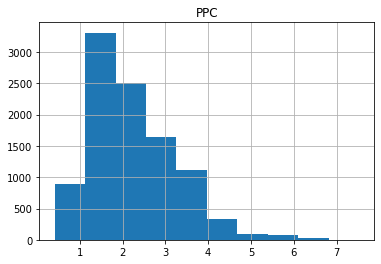

In [20]:
fluxes[["PPC"]].hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

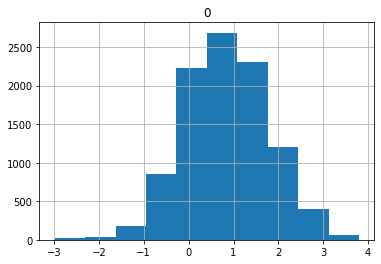

In [21]:
pd.DataFrame(updated[["PYK"]].to_numpy() - updated[["PPS"]].to_numpy()).hist()

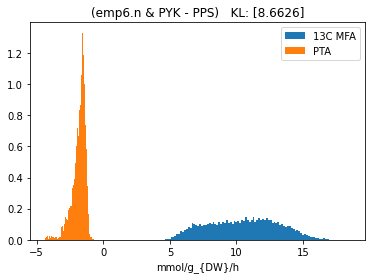

In [31]:
plt.hist(hops1[["emp6.n"]], density=True, bins=100,label="13C MFA")
emp6temp = pd.DataFrame(fluxes.loc[:,"PYK"] - fluxes.loc[:,"PPS"])
plt.hist(emp6temp, density=True, bins=100,label="PTA")
plt.legend(prop={'size': 10})
KLemp6 = smoothed_hist_kl_distance(emp6temp,hops1.loc[:,"emp6.n"])
plt.title("(emp6.n & PYK - PPS)   KL: " + str(KLemp6.round(4)))
plt.xlabel('mmol/g_{DW}/h')
plt.show()

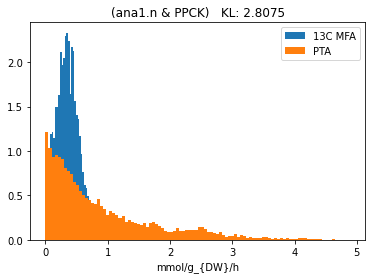

In [32]:
plt.hist(hops1[["ana1.n"]], density=True, bins=100,label="13C MFA")

plt.hist(fluxes[["PPCK"]], density=True, bins=100,label="PTA")
KLana1 = smoothed_hist_kl_distance(fluxes.loc[:,"PPCK"],hops1.loc[:,"ana1.n"])
plt.title("(ana1.n & PPCK)   KL: " + str(KLana1.round(4)))
plt.legend(prop={'size': 10})
plt.xlabel('mmol/g_{DW}/h')
plt.show()

In [24]:
plt.hist(uniform2[["emp6.n"]], density=True, bins=100,label="HOPS")
emp6temp = pd.DataFrame(fluxes.loc[:,"PYK"] - fluxes.loc[:,"PPS"])
plt.hist(emp6temp, density=True, bins=100,label="TFS")
plt.legend(prop={'size': 10})
KLemp6 = smoothed_hist_kl_distance(emp6temp,uniform2.loc[:,"emp6.n"])
plt.title("KL: " + str(KLemp6.round(4)))
plt.show()

NameError: name 'uniform2' is not defined

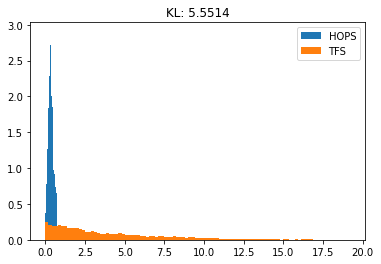

In [62]:
plt.hist(uniform2[["ana1.n"]], density=True, bins=100,label="HOPS")

plt.hist(fluxes[["PPCK"]], density=True, bins=100,label="TFS")
KLana1 = smoothed_hist_kl_distance(fluxes.loc[:,"PPCK"],uniform2.loc[:,"ana1.n"])
plt.title("KL: " + str(KLana1.round(4)))
plt.legend(prop={'size': 10})
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_histogram.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

In [35]:
import arviz as az
rhatsU = []
#kls=[]
for i in hops1.columns:
    df = pd.DataFrame()
    seed1 = hops1[i]
    seed2 = hops2[i]
    df =df.append(seed1).append(seed2)
    b = df.to_numpy()
    r= az.rhat(b)
    #kl = entropy(seed1,seed5)
    rhatsU.append(round(r,2))
    #kls.append(round(kl,2))

rhatsU

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.02,
 1.06,
 1.0,
 1.0,
 1.0,
 1.0,
 1.01,
 1.03,
 1.0,
 1.0,
 1.0,
 1.01,
 1.0,
 1.0,
 1.04,
 1.0,
 1.0,
 1.01]

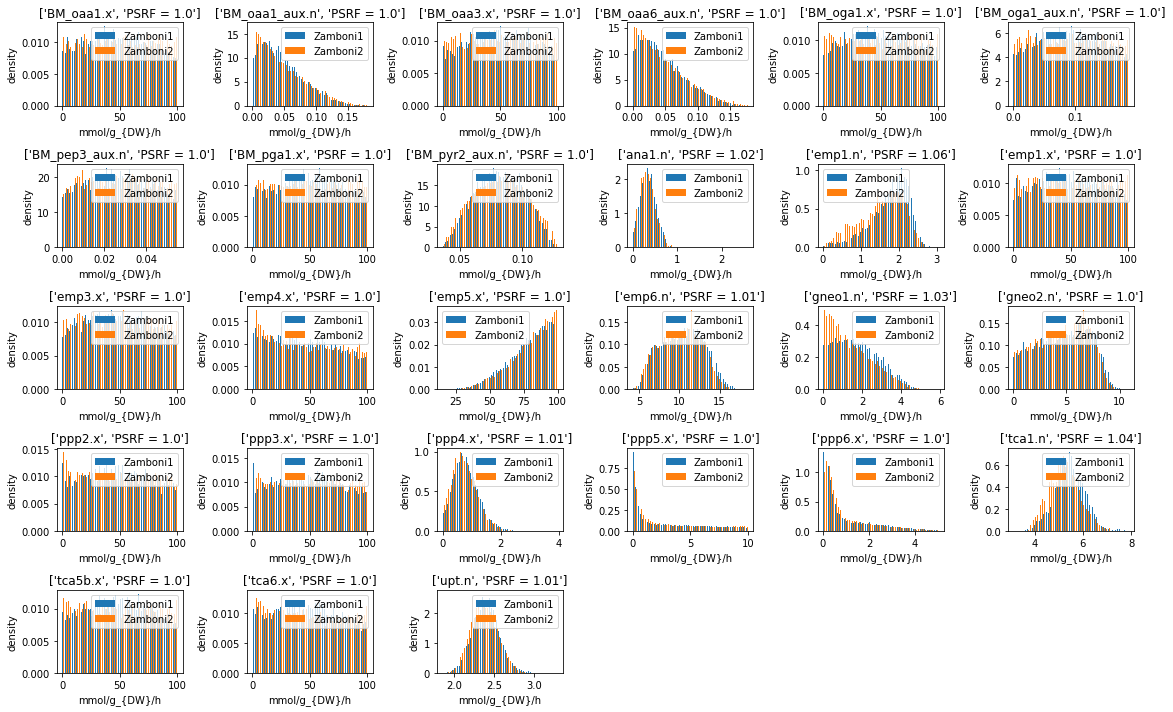

In [41]:
num_rxns = hops1.shape[1]
n_cols = 6
n_rows = math.ceil(num_rxns / n_cols)

fig=plt.figure(figsize=(16, 2*n_rows))
for i in range(num_rxns):
    kldiv = "PSRF = " + str(rhatsU[i])
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    ax.hist([hops1[:10000].iloc[:, i],hops2[:10000].iloc[:,i]], bins=50, density=True,label = ["Zamboni1","Zamboni2"])
    #X = np.linspace(min(min(updated[:10000].iloc[:, i]),min(fluxes[:10000].iloc[:, i])), max(max(updated[:10000].iloc[:, i]),max(fluxes[:10000].iloc[:, i])), 100)
    #aaaa = scipy.stats.rv_histogram(np.histogram(updated[:10000].iloc[:, i], bins=50))
    #bbbb = scipy.stats.rv_histogram(np.histogram(fluxes[:10000].iloc[:, i], bins=50))
    #ax.plot(X, aaaa.pdf(X), label='PDF')
    #ax.plot(X, bbbb.pdf(X), label='PDF')
    #fluxes.iloc[:, i]]
    ax.legend(prop={'size': 10})
    #ax.hist(, bins=20, density=True)
    ax.set_xlabel('mmol/g_{DW}/h')
    ax.set_ylabel('density')
    ax.set_title([hops1.columns[i],kldiv])#model1.reactions[i].id
fig.tight_layout()
plt.show()